# MIE1624 Assignment 1

Import Libraries


In [1]:
import numpy as np
import pandas as pd
import re
import html

## 1. Data Cleaning

Load files from current directory

In [2]:
stops = open("stop_words.txt","r")
stopWords = stops.read().replace('\t','\n').split('\n')
airlineTweets = pd.read_csv("US_airline_tweets.csv")
genericTweets = pd.read_csv("generic_tweets.txt")

### Define data cleaning methods:

In [3]:
#Method 1 - Remove all non ASCII charaters such as 'å'
def non_ascii_rm(text):
    allAscii = text.encode("ascii", errors="ignore").decode()
    return allAscii
    
#Method 2 - Remove all html tags and attributes
def html_tag_rm(text):
    noTag = re.compile(r"<.*?>").sub("", text)
    return noTag

#Method 3 - Replace Html character codes with ASCII equivalent
def ascii_rpl(text):
    return(html.unescape(text))

#Method 4 - Remove all URLs
def url_rm(text):
    return(re.compile(r"\w+://\S*").sub("", text))

#Method 5 - Remove all stopwords - loaded from stopword.txt
def stop_words_rm(stopWords,text):
    filtered_words = [word for word in text.split(" ") if word not in stopWords]
    return filtered_words

#Wraper function to preform all data cleaning method
def cleanText(text):
    global stopWords
    allAscii = non_ascii_rm(text.lower()) #make sure all lowercase
    noTag = html_tag_rm(allAscii) 
    asciiRpl = ascii_rpl(noTag)
    noUrl = url_rm(asciiRpl)
    noStopWords = stop_words_rm(stopWords, noUrl)
    return(" ".join(noStopWords))

Clean Data using methods defined above

In [4]:
cleandata = lambda x: cleanText(x)
genericTweets["text"] = genericTweets["text"].map(cleandata)
airlineTweets["text"] = airlineTweets["text"].map(cleandata)

genericTweets.to_csv("generic_tweets_clean.csv")
airlineTweets.to_csv("US_airline_tweets_clean.csv")

## 2. Exploratory Analysis

In [5]:
atUser = pd.DataFrame(columns=['atUser'])
hashTag = pd.DataFrame(columns=['hashTag'])

#Method to find regex pattern - used for finding "@"s and "#"s
def getAtUsers(text, pattern):
    return pattern.findall(text)

#find airlines mentioned with "@"
atUserRe = re.compile(r'@\w+')
for t in airlineTweets["text"]:
    for user in getAtUsers(t, atUserRe):
        atUser = atUser.append({"atUser": user},ignore_index=True)
        
atAirCount = atUser.groupby(["atUser"]).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False).head(20)
atAirCount

,atUser,counts
626,@united,3192
636,@usairways,2607
47,@americanair,2462
556,@southwestair,1788
318,@jetblue,1519
648,@virginamerica,344
181,@delta,60
488,@phlairport,17
299,@imaginedragons,17
188,@dfwairport,12


Text(0, 0.5, 'counts')

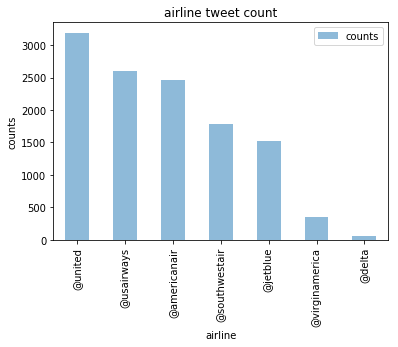

In [37]:
import matplotlib.pyplot as plt
#atAirCount = atAirCount.set_index('atUser')
aa = atAirCount.set_index("atUser")
aa.index.name="airline"
plot = aa.head(7).plot(kind="bar",alpha=0.5, title="airline tweet count")
plot.set_ylabel("counts")


In [ ]:
df = pd.DataFrame(columns=['A'])
df.append({"A": "anc"}, ignore_index=True)